# 03 Portfolio Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
import kungfu as kf

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Settings

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [5]:
%matplotlib inline

In [6]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

## Load data

In [7]:
return_matrix = pd.read_csv('../data/processed/return_matrix.csv').set_index('date')
return_matrix.index = pd.to_datetime(return_matrix.index, yearfirst=True)
return_matrix.columns.name = 'permno'

In [8]:
df_ff_raw = pd.read_pickle('../data/external/df_ff_raw.pkl')

### Prepare

In [9]:
df_portfolio = kf.FinancialDataFrame(return_matrix.unstack())
df_portfolio = df_portfolio.rename(columns={0: 'daily_return'})

In [10]:
inc = pd.read_csv('../data/external/IN_yearly.csv', header=None)
outg = pd.read_csv('../data/external/OUT_yearly.csv', header=None)
opt_dates = return_matrix.index[return_matrix.index.year != pd.Series(return_matrix.index.year).shift(-1)][1:-1]

inc.index = return_matrix.columns
inc.columns = opt_dates
inc = inc.stack().to_frame().rename(columns={0: 'incoming'})

outg.index = return_matrix.columns
outg.columns = opt_dates
outg = outg.stack().to_frame().rename(columns={0: 'outgoing'})

df_portfolio = df_portfolio\
                .merge(inc, how='left', left_index=True, right_on=['permno','date'])\
                .merge(outg, how='left', left_index=True, right_on=['permno','date'])

In [11]:
capm = kf.FactorModel(df_ff_raw['mktrf'])
ff3f = kf.FactorModel(df_ff_raw[['mktrf','smb','hml']])

## Sort

In [12]:
portfolios = df_portfolio.sort_portfolios(['daily_return'], ['incoming'], method='sequential', n_sorts=10, lag=1)

In [33]:
df_portfolio.groupby(df_portfolio.index.get_level_values(1)).apply(lambda x: x.divide(x.sum()))

daily_return   5031.0000
incoming         18.0000
outgoing         18.0000
dtype: float64

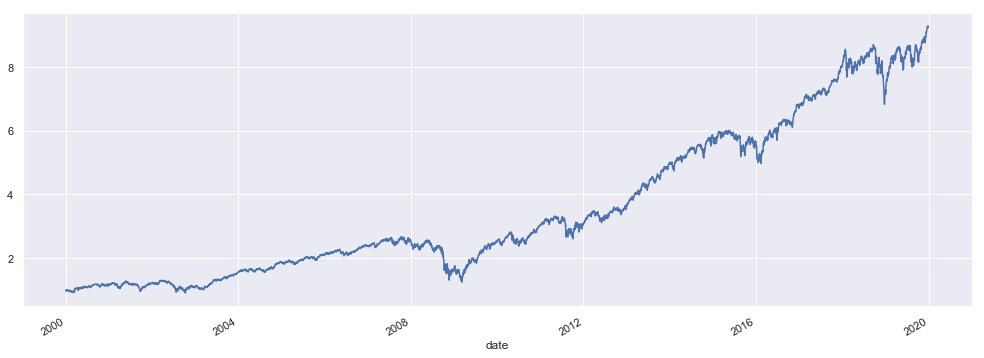

In [100]:
kf.FinancialSeries(df_portfolio['daily_return'].groupby(df_portfolio.index.get_level_values(1)).mean()).set_obstype('return').to_prices().plot()
plt.show()

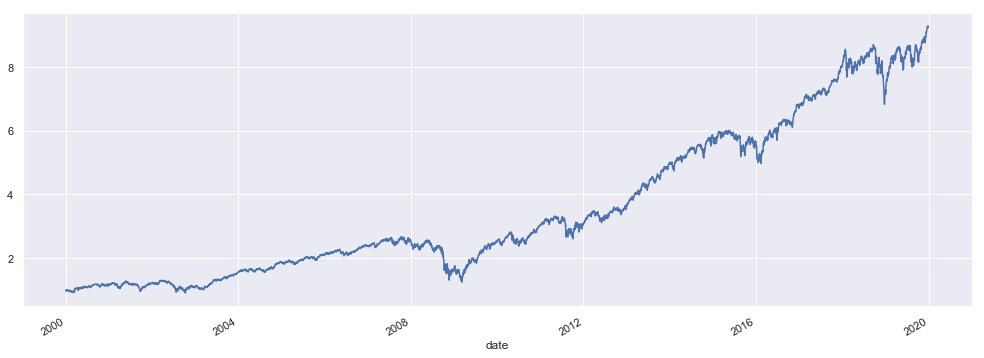

In [105]:
index = kf.portfolio.create_index(df_portfolio['daily_return'])
kf.FinancialSeries(index).set_obstype('return').to_prices().plot()
plt.show()

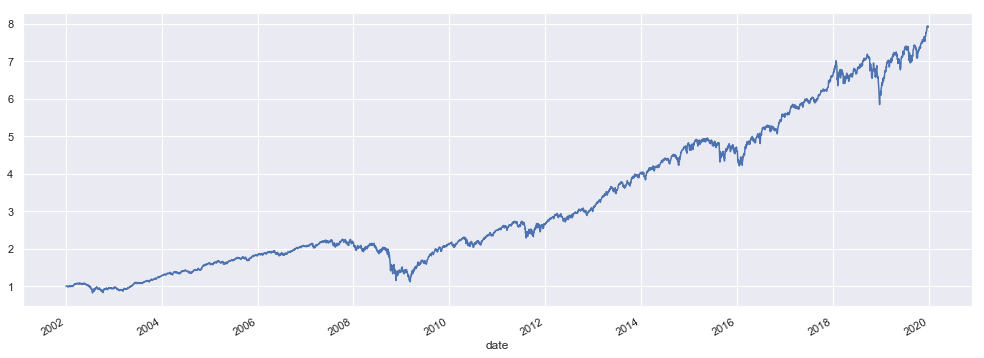

In [126]:
index2 = kf.portfolio.create_index(df_portfolio['daily_return'], df_portfolio['incoming']**(-1/2), lag=1)
kf.FinancialSeries(index2).set_obstype('return').to_prices().plot()
plt.show()

In [133]:
kf.FinancialSeries(index).set_obstype('return').summarise_performance(252)

Return p.a. (arithmetic)    0.1309
Return p.a. (geometric)     0.1180
Volatility p.a.             0.1965
Sharpe ratio                0.6008
t-stat                      2.9769
Total return                8.2747
Positive returns %         54.8002
VaR 95% (historic)         -0.0183
VaR 95% (parametric)       -0.0198
Expected shortfall 95%     -0.0291
Downside volatility         0.0128
Maximum drawdown           -0.5330
dtype: float64

In [132]:
kf.FinancialSeries(index2).set_obstype('return').summarise_performance(252)

Return p.a. (arithmetic)    0.1298
Return p.a. (geometric)     0.1221
Volatility p.a.             0.1711
Sharpe ratio                0.7133
t-stat                      3.2175
Total return                6.9308
Positive returns %         55.0872
VaR 95% (historic)         -0.0159
VaR 95% (parametric)       -0.0172
Expected shortfall 95%     -0.0258
Downside volatility         0.0113
Maximum drawdown           -0.5027
dtype: float64

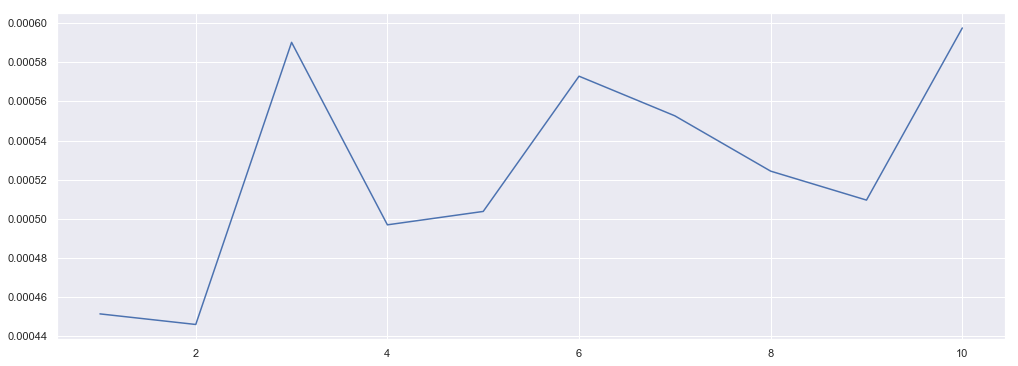

In [15]:
portfolios.returns.unstack().mean().plot()
plt.show()

In [16]:
kf.FinancialSeries(portfolios.returns.unstack()[10]).set_obstype('return').summarise_performance(252)

Return p.a. (arithmetic)    0.1506
Return p.a. (geometric)     0.1014
Volatility p.a.             0.3291
Sharpe ratio                0.3082
t-stat                      1.9403
Total return                4.6789
Positive returns %         53.0788
VaR 95% (historic)         -0.0312
VaR 95% (parametric)       -0.0335
Expected shortfall 95%     -0.0477
Downside volatility         0.0208
Maximum drawdown           -0.6842
dtype: float64

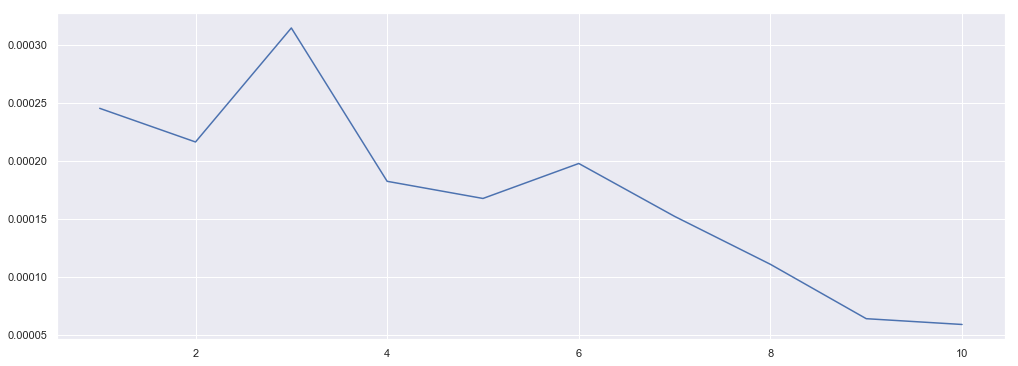

In [18]:
ff3f.fit(portfolios.returns.unstack()).alphas.plot()
plt.show()

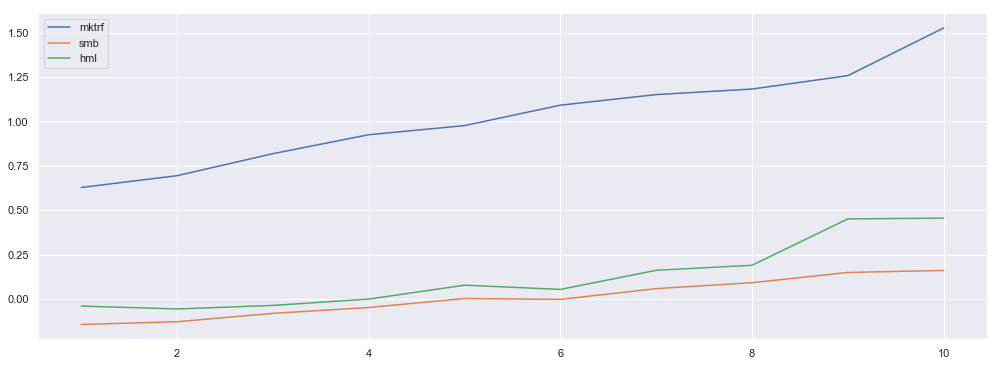

In [19]:
ff3f.fit(portfolios.returns.unstack()).betas.plot()
plt.show()

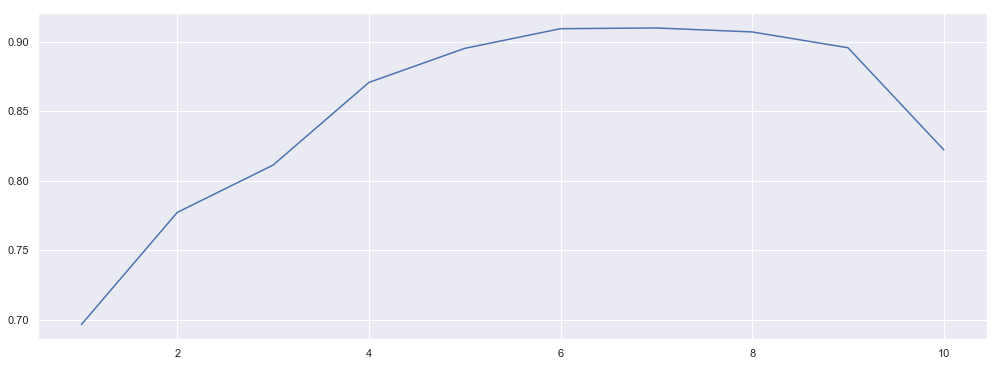

In [20]:
ff3f.fit(portfolios.returns.unstack()).r_squares.plot()
plt.show()

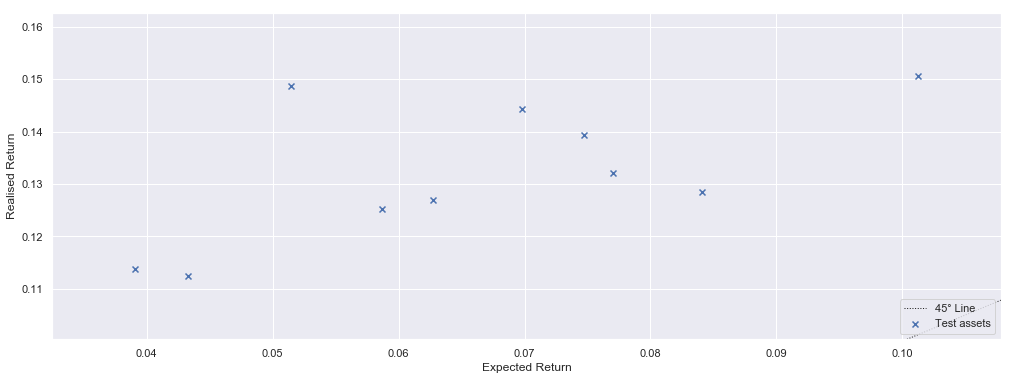

In [23]:
_ = capm.fit(portfolios.returns.unstack()).plot_predictions(252)
plt.show()

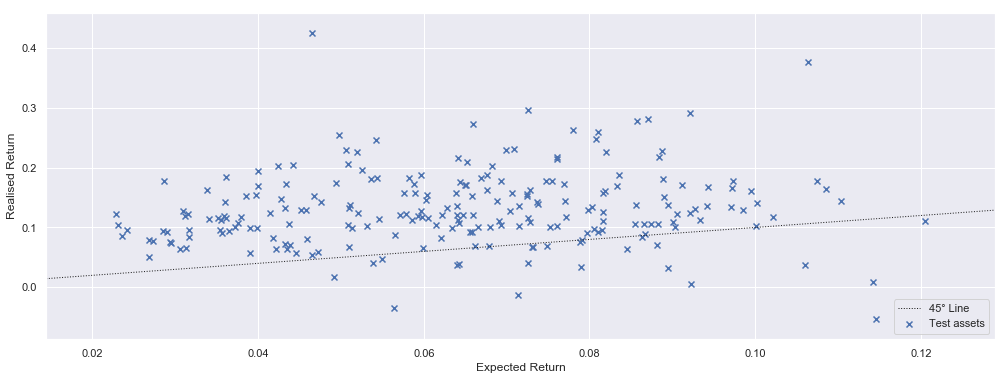

In [45]:
_ = capm.fit(return_matrix).plot_predictions(252)

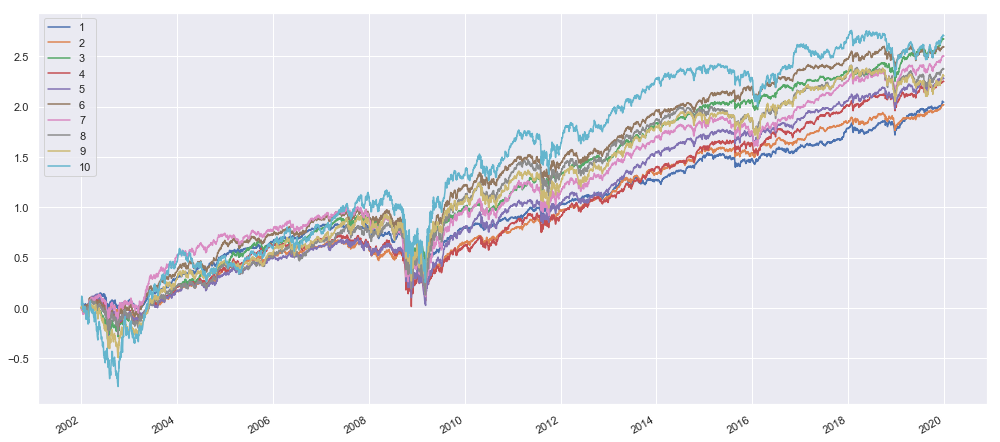

In [24]:
portfolios.returns.unstack().cumsum().plot(figsize=[17,8])
plt.show()

In [24]:
df_panel['capm_beta'] = np.nan
df_panel['capm_alpha'] = np.nan
for end in opt_indices:
    start = end-498
    data = return_matrix.iloc[start:end+1,:]
    year = return_matrix.index[end].year
    results = capm.fit(data)
    
    df_panel.loc[[(asset,year) for asset in return_matrix.columns],'capm_beta'] = results.betas.values
    df_panel.loc[[(asset,year) for asset in return_matrix.columns],'capm_alpha'] = results.alphas.values

In [25]:
df_performance = kf.FinancialDataFrame()
df_performance['return_1y'] = (return_matrix.groupby(pd.Grouper(freq='Y')).mean()*252).stack().swaplevel(0,1)
df_performance['return_1m'] = (return_matrix.groupby(pd.Grouper(freq='M')).mean()*252).stack().swaplevel(0,1)
df_performance['return_3m'] = (return_matrix.groupby(pd.Grouper(freq='Q')).mean()*252).stack().swaplevel(0,1)

df_performance['variance_1y'] = (return_matrix.groupby(pd.Grouper(freq='Y')).var()*252).stack().swaplevel(0,1)
df_performance['variance_1m'] = (return_matrix.groupby(pd.Grouper(freq='M')).var()*252).stack().swaplevel(0,1)
df_performance['variance_3m'] = (return_matrix.groupby(pd.Grouper(freq='Q')).var()*252).stack().swaplevel(0,1)

df_performance.index = pd.MultiIndex.from_arrays([df_performance.index.get_level_values(0),df_performance.index.get_level_values(1).year])

df_panel = df_panel.merge(df_performance, how='outer', left_index=True, right_on=['permno','date'])